Note: in this notebook theta is t_total (life-span to be estimated) and x_vector corresponds to observed 't' values (current age values)

In [2]:
# setup the environment
import nengo
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.stats as st
% matplotlib inline

### Parametric empirical bayes


$$p(x/\alpha) = \int_{\theta}  p(x/\theta)p(\theta/\alpha) d\theta$$

Find $$\hat{\alpha}$$  and $$p(\theta/\hat{\alpha})$$

Then find the posterior:
$$p(\theta/x) = p(x/\theta) p(\theta/\hat{\alpha})$$

 

In [3]:
# Function to sample random values from a skewed gaussian distribution
def randn_skew(N, alpha=0.0, loc=0.0, scale=1.0):
    sigma = alpha / np.sqrt(1.0 + alpha**2) 
    u0 = np.random.randn(N)
    v = np.random.randn(N)
    u1 = (sigma*u0 + np.sqrt(1.0 - sigma**2)*v) * scale
    u1[u0 < 0] *= -1
    u1 = u1 + loc
    return u1
    
#print randn_skew_fast(100, alpha=-4, loc=97, scale=28)

alpha_hat:  100


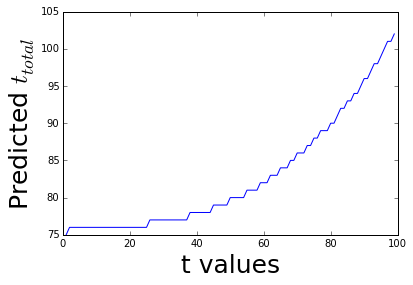

In [4]:
# assuming that maximum possible age is 120 yrs
max_age = 120


# observed values of current ages (i.e., t value)
# Here I am assuming that these are current ages of multiple people
# The goal is to estimate a prior distribution based on these ages
#x_vector = [5, 25, 32, 45, 55, 65, 75, 80, 90, 100, 107]
x_vector = [5, 32, 55, 75, 90, 107]    

'''
# Add more data to get a better estimate    
obs = randn_skew(100, alpha=-4, loc=97, scale=28)
for i in obs:
    x_vector.append(i)
'''

# all possible values of t_total (from 1 to 120)
thetas = np.linspace(start=1, stop=max_age, num=max_age)   # all possible values of theta (from 1 to 120)

# likelihood function given the set of observations x1, x2, x3, x4, x5
# Since these are iid observations, likelihood is just the product of all
def cal_likelihood(x):
    like = np.asarray([1/p for p in thetas])   #  p(X/theta)
    like[0:x-1] = [0]*np.asarray(x-1)          # likelihood is 1/theta for theta >= x and 0 otherwise
    return like

likelihood = np.ones(max_age)
for i in x_vector:
    likelihood = np.multiply(likelihood, cal_likelihood(i))    
     

# declare a matrix which will store p_theta along columns for each given alpha
# theta varies along rows, and alpha varies along columns
p_matrix = np.zeros((len(thetas), max_age))
for x in np.arange(1,max_age+1,1):
    p_theta = [(st.skewnorm.pdf(p, a=-4, loc=x, scale=28)) for p in thetas]
    p_theta = p_theta/np.sum(p_theta)    # normalize prior (to sum up to 1)
    p_matrix[:, x-1] = p_theta
    

# Now compute p(X/alpha) by marginalizing out theta for each alpha
marginpost_set = np.dot(likelihood, p_matrix.T)   # this will be a list of dimentions (1 x max_age)
#pick the max value and find the corresponding alpha
alpha_hat = np.argmax(marginpost_set) + 1

print "alpha_hat: ", alpha_hat

# p(theta/alpha_hat): Note that I am considering loc parameter to be alpha (unknown)
# Assuming that a and scale parameters are known
p_theta_ga = [(st.skewnorm.pdf(p, a=-4, loc=alpha_hat, scale=28)) for p in thetas]
p_x = np.sum(np.multiply(p_theta_ga, likelihood)) 
posterior = np.multiply(p_theta_ga, likelihood) / p_x

def median(posterior):
    median = 0
    for a in np.arange(len(posterior)):
        cum = sum(posterior[:a+1])
        if cum == 0.5 or cum > 0.5:
            median = a + 1
            break
    return median

predictions = []
for x in np.arange(1,100,1):
    like = [1/p for p in thetas]  #  p(X/theta)
    like[0:x-1] = [0]*(x-1)  # likelihood is 1/theta for theta >= x and 0 otherwise
    p_x = np.sum(np.multiply(p_theta_ga, like))       # already sums to 1
    posterior = np.multiply(p_theta_ga, like) / p_x   # already sums to 1
    prediction = median(posterior)
    predictions.append(prediction)
    
plt.figure()
plt.plot(np.arange(1,100,1), predictions)
plt.xlabel("t values", fontsize=25)
plt.ylabel("Predicted $t_{total}$", fontsize=25)
plt.show()

### Iterative loop method as described in HBB book

Find posterior assuming a flat prior in the beginning:
$$p(\theta/x) = p(x/\theta) p(\theta)$$

$$p(\alpha/x) = \int_{\theta}  p(\alpha/\theta) p(\theta/x) d\theta$$

Find $$\hat{\alpha}$$  and $$p(\theta/\hat{\alpha})$$

Then find the posterior:
$$p(\theta/x) = p(x/\theta) p(\theta/\hat{\alpha})$$

Then repeat the above steps until convergence.

In [24]:
# Empirical Bayes with BG looping 

# assuming that maximum possible age is 120 yrs
max_age = 120


# observed values of current ages (i.e., t value)
# Here I am assuming that these are current ages of multiple people
# The goal is to estimate a prior distribution based on these ages
#x_vector = [5, 25, 32, 45, 55, 65, 75, 80, 90, 100, 107]
x_vector = [5, 32, 55, 75, 90, 107]


'''
# Add more data to get a better estimate  
obs = randn_skew(100, alpha=-4, loc=97, scale=28)
for i in obs:
    x_vector.append(i)  
'''    
    
# all possible values of t_total (from 1 to 120)
thetas = np.linspace(start=1, stop=max_age, num=max_age)   # all possible values of theta (from 1 to 120)

# likelihood function given the set of observations x1, x2, x3, x4, x5
# Since these are iid observations, likelihood is just the product of all
def cal_likelihood(x):
    like = np.asarray([1/p for p in thetas])   #  p(X/theta)
    like[0:x-1] = [0]*np.asarray(x-1)          # likelihood is 1/theta for theta >= x and 0 otherwise
    return like

likelihood = np.ones(max_age)
for i in x_vector:
    likelihood = np.multiply(likelihood, cal_likelihood(i))   
    
    
p_theta = np.ones(len(thetas))     # p(theta) - a uniform prior
p_theta = p_theta/np.sum(p_theta)  # normalize 


# declare a matrix which will store p_theta along columns for each given alpha
# theta varies along rows, and alpha varies along columns
# Here I have assumed that p(alpha/theta) is proportional to p(theta/alpha)
p_matrix = np.zeros((len(thetas), max_age))
for x in np.arange(1,max_age+1,1):
    p_theta = [(st.skewnorm.pdf(p, a=-4, loc=x, scale=28)) for p in thetas]
    p_theta = p_theta/np.sum(p_theta)    # normalize prior (to sum up to 1)
    p_matrix[:, x-1] = p_theta
    

# compute the posterior with uniform prior
#p_x = np.sum(np.multiply(p_theta, likelihood)) 
p_thx = np.multiply(likelihood, p_theta)  #/ p_x

p_ax = np.dot(p_matrix, p_thx)   # this will be a list of dimentions (1 x max_age)
#pick the max value and find the corresponding alpha
alpha_hat = np.argmax(p_ax) + 1

print "alpha_hat: ", alpha_hat    


# bg loop structure
for i in range(10):
    # p(theta/alpha_hat): Note that I am considering loc parameter to be alpha (unknown)
    # Assuming that a and scale parameters are known
    p_theta_ga = [(st.skewnorm.pdf(p, a=-4, loc=alpha_hat, scale=28)) for p in thetas]
    
    # compute the posterior
    #p_x = np.sum(np.multiply(p_theta_ga, likelihood)) 
    p_thx = np.multiply(likelihood, p_theta_ga)  #/ p_x

    p_ax = np.dot(p_matrix, p_thx)   # this will be a list of dimentions (1 x max_age)
    #pick the max value and find the corresponding alpha
    alpha_hat = np.argmax(p_ax) + 1
    print "alpha_hat: ", alpha_hat    


alpha_hat:  100
alpha_hat:  97
alpha_hat:  97
alpha_hat:  97
alpha_hat:  97
alpha_hat:  97
alpha_hat:  97
alpha_hat:  97
alpha_hat:  97
alpha_hat:  97
alpha_hat:  97


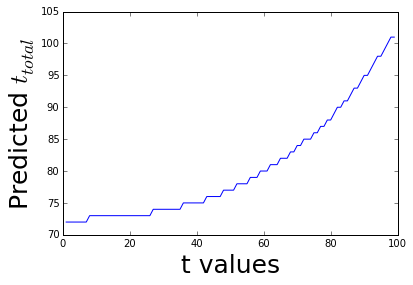

In [25]:
def median(posterior):
    median = 0
    for a in np.arange(len(posterior)):
        cum = sum(posterior[:a+1])
        if cum == 0.5 or cum > 0.5:
            median = a + 1
            break
    return median

predictions = []
for x in np.arange(1,100,1):
    like = [1/p for p in thetas]  #  p(X/theta)
    like[0:x-1] = [0]*(x-1)  # likelihood is 1/theta for theta >= x and 0 otherwise
    p_x = np.sum(np.multiply(p_theta_ga, like))       # already sums to 1
    posterior = np.multiply(p_theta_ga, like) / p_x   # already sums to 1
    prediction = median(posterior)
    predictions.append(prediction)
    
plt.figure()
plt.plot(np.arange(1,100,1), predictions)
plt.xlabel("t values", fontsize=25)
plt.ylabel("Predicted $t_{total}$", fontsize=25)
plt.show()

I have shown that the standard empirical bayes doesn't do very well because the number of observed data points is very small.
However, the interative loop method performs well even with the small number of observed data points. 